# This is a second order wave equation with Dirichlet boundary conditions used to test different minimizers. 

We just implement the wave equation as a toy model to try different minimizers and strategies. 

Let's solve this 1-dimensional wave equation:

```math
\begin{align*}
∂^2_t u(x, t) = c^2 ∂^2_x u(x, t) \quad & \textsf{for all } 0 < x < 1 \text{ and } t > 0 \, , \\
u(0, t) = u(1, t) = 0 \quad & \textsf{for all } t > 0 \, , \\
u(x, 0) = x (1-x)     \quad & \textsf{for all } 0 < x < 1 \, , \\
∂_t u(x, 0) = 0       \quad & \textsf{for all } 0 < x < 1 \, , \\
\end{align*}
```

with grid discretization `dx = 0.1` and physics-informed neural networks.

Further, the solution of this equation with the given boundary conditions is presented.


In [15]:
using NeuralPDE, Lux, LuxCUDA, Optimization, OptimizationOptimJL
using ModelingToolkit, IntervalSets, Plots, JLD2
using ComponentArrays, Random
const gpud = gpu_device()

@parameters t, x
@variables u(..)
Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)

#2D PDE
C = 1
eq = Dtt(u(t, x)) ~ C^2 * Dxx(u(t, x))

# Initial and boundary conditions
bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(t, 1) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x), #for all 0 < x < 1
    Dt(u(0, x)) ~ 0.0] #for all  0 < x < 1]

# Space and time domains
ti = 0.0
tf = 1.0
xi = 0.0
xf = 1.0
domains = [t ∈ Interval(ti, tf),
    x ∈ Interval(xi, xf)]
# Discretization
dx = 0.1

@named wave = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Neural network
chain = Chain(Dense(2, 16, σ), Dense(16, 16, σ), Dense(16, 1))

ps = Lux.setup(Random.default_rng(), chain)[1]
ps = ps |> ComponentArray |> gpud .|> Float64

strategy = QuasiRandomTraining(100)
#strategy = QuadratureTraining(; abstol = 1e-6, reltol = 1e-6, batch = 200)
#strategy = GridTraining(0.05)
discretization = PhysicsInformedNN(chain, strategy; init_params = ps#, param_estim = true
#, additional_loss = additional_loss
)

prob = discretize(wave, discretization)
sym_prob = symbolic_discretize(wave, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

loss = Float64[]
callback = function (p, l)
    push!(loss, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    return false
end
#discretization = PhysicsInformedNN(chain, GridTraining(dx))

@named pde_system = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])
prob = discretize(pde_system, discretization)



OptimizationProblem. In-place: true
u0: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:48, Axis(weight = ViewAxis(1:32, ShapedAxis((16, 2))), bias = ViewAxis(33:48, Shaped1DAxis((16,))))), layer_2 = ViewAxis(49:320, Axis(weight = ViewAxis(1:256, ShapedAxis((16, 16))), bias = ViewAxis(257:272, Shaped1DAxis((16,))))), layer_3 = ViewAxis(321:337, Axis(weight = ViewAxis(1:16, ShapedAxis((1, 16))), bias = ViewAxis(17:17, Shaped1DAxis((1,))))))}}}(layer_1 = (weight = [0.7165217995643616 -0.3503269851207733; 0.7676129341125488 -0.05567615479230881; … ; -0.3756350874900818 1.1410764455795288; 0.1518690437078476 -0.8260506987571716], bias = [0.39693009853363037, -0.2702159285545349, -0.4590318500995636, -0.4248726963996887, 0.4372956454753876, 0.3818279504776001, 0.3966864049434662, -0.46499869227409363, 0.09352006018161774, -0.023953402414917946, 0.16668716073036194, -0.4821817874908447, -0.18936984241008759, 0.48424023389816284, 0.39294382929

In [16]:

opt = OptimizationOptimJL.BFGS()
res = Optimization.solve(prob, opt; callback, maxiters = 12000)
phi = discretization.phi

loss: 1.2860255334515043
pde_losses: [2.6666159113091225e-5]
bcs_losses: [0.3458246501478744, 0.36618854910889487, 0.5732743577111922, 0.0007075861308720483]
loss: 0.34182211106433186
pde_losses: [4.045646495187627e-5]
bcs_losses: [0.14672623605879656, 0.14238385375082696, 0.052432533985532916, 0.0002418857568541219]
loss: 0.022713607653247887
pde_losses: [2.7396463513857694e-5]
bcs_losses: [0.002932229475628275, 0.002367973347138772, 0.016908609838056213, 0.00047721152512509413]
loss: 0.022335733180680207
pde_losses: [3.476148617511114e-5]
bcs_losses: [0.003181390426241496, 0.003449858993898137, 0.014572483231469957, 0.001095424393606115]
loss: 0.02215483109290739
pde_losses: [4.229920931205576e-5]
bcs_losses: [0.0022801718013565455, 0.003012411128819985, 0.015200877856772585, 0.0016238908708982515]
loss: 0.022157430771972363
pde_losses: [4.186547007583988e-5]
bcs_losses: [0.0022798917298022725, 0.0030096767823362385, 0.015203044339949023, 0.0016240938820923862]
loss: 0.02177258500245

NeuralPDE.Phi{StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.Tru

In [ ]:
using Plots

plot(loss, yscale=:log10, xlabel="Iteration", ylabel="Loss", title="Loss vs Iteration"  )
#savefig("loss_pure_2_wave_BFGS.png")

"/users/oreula/Julia/PINN/loss_pure_2_wave_BFGS.png"

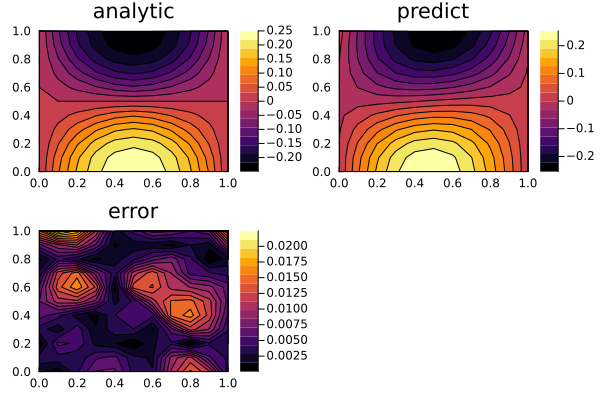

In [18]:
#using Plots

ts = ti:dx:tf
xs = xi:dx:xf
function analytic_sol_func(t, x)
    sum([(8 / (k^3 * pi^3)) * sin(k * pi * x) * cos(C * k * pi * t) for k in 1:2:50000])
end

u_predict = [first(Array(phi([t, x], res.u))) for t in ts for x in xs]
u_real = [analytic_sol_func(t, x) for t in ts for x in xs]

diff_u = abs.(u_predict .- u_real)
p1 = plot(ts, xs, u_real, linetype = :contourf, title = "analytic");
p2 = plot(ts, xs, u_predict, linetype = :contourf, title = "predict");
p3 = plot(ts, xs, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)
